# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import time

from cs231n.classifiers.neural_net import TwoLayerNet

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720925453725e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [5]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 4.447646e-11
W2 max relative error: 3.440708e-09
b1 max relative error: 2.738421e-09
W1 max relative error: 3.561318e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.017149607938732093


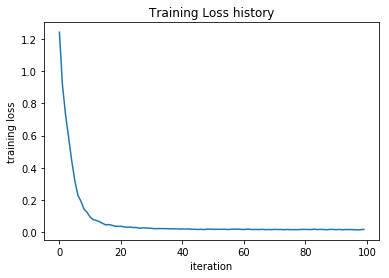

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [7]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [8]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



iteration 0 / 1000: loss 2.302954
iteration 100 / 1000: loss 2.302550
iteration 200 / 1000: loss 2.297648
iteration 300 / 1000: loss 2.259602
iteration 400 / 1000: loss 2.204170
iteration 500 / 1000: loss 2.118565
iteration 600 / 1000: loss 2.051535
iteration 700 / 1000: loss 1.988466
iteration 800 / 1000: loss 2.006591
iteration 900 / 1000: loss 1.951473
Validation accuracy:  0.287


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

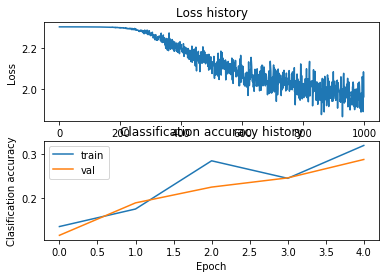

In [9]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend(loc='best')
plt.show()

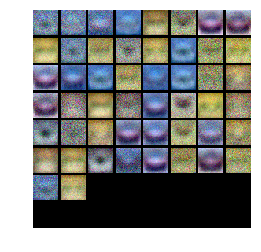

In [10]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

/home/reut/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/reut/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/reut/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/home/reut/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and t

0  hs  10  lr  1.8964402962553993e-08  reg  0.00010920612472182481  decay  0.95  train accuracy:  0.11336734693877551  val accuracy:  0.112
0  hs  10  lr  1.8964402962553993e-08  reg  0.00010920612472182481  decay  0.99  train accuracy:  0.11851020408163265  val accuracy:  0.113
1  hs  10  lr  0.0006063236308073668  reg  820.9826283217747  decay  0.95  train accuracy:  0.09989795918367347  val accuracy:  0.105
1  hs  10  lr  0.0006063236308073668  reg  820.9826283217747  decay  0.99  train accuracy:  0.10042857142857142  val accuracy:  0.079
2  hs  10  lr  0.0007078741755460182  reg  0.05937215155143042  decay  0.95  train accuracy:  0.405  val accuracy:  0.409
2  hs  10  lr  0.0007078741755460182  reg  0.05937215155143042  decay  0.99  train accuracy:  0.4045918367346939  val accuracy:  0.402
3  hs  10  lr  3.675862133238818e-05  reg  1.391923362377262e-05  decay  0.95  train accuracy:  0.16518367346938775  val accuracy:  0.158
3  hs  10  lr  3.675862133238818e-05  reg  1.391923362377

30  hs  10  lr  1.1571200927260098e-05  reg  1.9939296384032057  decay  0.99  train accuracy:  0.1684081632653061  val accuracy:  0.183
31  hs  10  lr  6.873636313820667e-07  reg  8.739571636186119e-05  decay  0.95  train accuracy:  0.111  val accuracy:  0.121
31  hs  10  lr  6.873636313820667e-07  reg  8.739571636186119e-05  decay  0.99  train accuracy:  0.10051020408163265  val accuracy:  0.098
32  hs  10  lr  4.895687501287296e-06  reg  0.0013133645620562967  decay  0.95  train accuracy:  0.11626530612244898  val accuracy:  0.116
32  hs  10  lr  4.895687501287296e-06  reg  0.0013133645620562967  decay  0.99  train accuracy:  0.16555102040816327  val accuracy:  0.164
33  hs  10  lr  6.242527819689906e-06  reg  93476.73014904927  decay  0.95  train accuracy:  0.09975510204081632  val accuracy:  0.112
33  hs  10  lr  6.242527819689906e-06  reg  93476.73014904927  decay  0.99  train accuracy:  0.09989795918367347  val accuracy:  0.105
34  hs  10  lr  1.4386648020806165e-07  reg  0.00267

/home/reut/cs231n_assignment1/cs231n/classifiers/neural_net.py:101: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(scores[np.arange(N), y]))
/home/reut/cs231n_assignment1/cs231n/classifiers/neural_net.py:98: RuntimeWarning: overflow encountered in subtract
  scores = scores - np.max(scores, axis=1)[:, np.newaxis]  # for numerical stability
/home/reut/cs231n_assignment1/cs231n/classifiers/neural_net.py:103: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
/home/reut/cs231n_assignment1/cs231n/classifiers/neural_net.py:98: RuntimeWarning: invalid value encountered in subtract
  scores = scores - np.max(scores, axis=1)[:, np.newaxis]  # for numerical stability
/home/reut/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/reut/cs231n_assignment1/cs231n/classifiers/neural_net.py:120: Run

55  hs  10  lr  0.00040833800992413097  reg  5785.279666696206  decay  0.95  train accuracy:  0.10026530612244898  val accuracy:  0.087
55  hs  10  lr  0.00040833800992413097  reg  5785.279666696206  decay  0.99  train accuracy:  0.10026530612244898  val accuracy:  0.087
56  hs  10  lr  2.417804896514358e-05  reg  1.1485929163016247e-05  decay  0.95  train accuracy:  0.17942857142857144  val accuracy:  0.178
56  hs  10  lr  2.417804896514358e-05  reg  1.1485929163016247e-05  decay  0.99  train accuracy:  0.16175510204081633  val accuracy:  0.158
57  hs  10  lr  2.206593704399372e-07  reg  0.06318534088720809  decay  0.95  train accuracy:  0.11608163265306122  val accuracy:  0.118
57  hs  10  lr  2.206593704399372e-07  reg  0.06318534088720809  decay  0.99  train accuracy:  0.09548979591836734  val accuracy:  0.097
58  hs  10  lr  5.507835332534113e-08  reg  0.3956363862535508  decay  0.95  train accuracy:  0.09944897959183674  val accuracy:  0.092
58  hs  10  lr  5.507835332534113e-08 

15  hs  50  lr  8.147936189020248e-05  reg  424.3142012027289  decay  0.95  train accuracy:  0.10044897959183674  val accuracy:  0.078
15  hs  50  lr  8.147936189020248e-05  reg  424.3142012027289  decay  0.99  train accuracy:  0.10044897959183674  val accuracy:  0.078
16  hs  50  lr  6.179850793257323e-06  reg  0.021606852756097  decay  0.95  train accuracy:  0.1896122448979592  val accuracy:  0.194
16  hs  50  lr  6.179850793257323e-06  reg  0.021606852756097  decay  0.99  train accuracy:  0.20077551020408163  val accuracy:  0.18
17  hs  50  lr  4.230538160248985e-05  reg  0.0011003513207785544  decay  0.95  train accuracy:  0.18685714285714286  val accuracy:  0.194
17  hs  50  lr  4.230538160248985e-05  reg  0.0011003513207785544  decay  0.99  train accuracy:  0.19816326530612244  val accuracy:  0.21
18  hs  50  lr  1.6950947497016998e-07  reg  0.07536262844635355  decay  0.95  train accuracy:  0.09922448979591837  val accuracy:  0.107
18  hs  50  lr  1.6950947497016998e-07  reg  0.

/home/reut/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


32  hs  50  lr  0.0001227342936366586  reg  42720.602223456866  decay  0.99  train accuracy:  0.10026530612244898  val accuracy:  0.087
33  hs  50  lr  1.0336765945546956e-07  reg  150.41749500719345  decay  0.95  train accuracy:  0.0736734693877551  val accuracy:  0.064
33  hs  50  lr  1.0336765945546956e-07  reg  150.41749500719345  decay  0.99  train accuracy:  0.10430612244897959  val accuracy:  0.115
34  hs  50  lr  2.5265530822050487e-07  reg  0.003261082641310488  decay  0.95  train accuracy:  0.09024489795918367  val accuracy:  0.101
34  hs  50  lr  2.5265530822050487e-07  reg  0.003261082641310488  decay  0.99  train accuracy:  0.11416326530612245  val accuracy:  0.134
35  hs  50  lr  0.00044856484639060917  reg  0.055192294195923426  decay  0.95  train accuracy:  0.44342857142857145  val accuracy:  0.457
35  hs  50  lr  0.00044856484639060917  reg  0.055192294195923426  decay  0.99  train accuracy:  0.4498367346938775  val accuracy:  0.421
36  hs  50  lr  1.6760689470658907e-

62  hs  50  lr  6.618506687037237e-08  reg  3980.966251209353  decay  0.99  train accuracy:  0.09620408163265307  val accuracy:  0.084
63  hs  50  lr  9.919009825726136e-06  reg  27209.086185756292  decay  0.95  train accuracy:  0.10042857142857142  val accuracy:  0.079
63  hs  50  lr  9.919009825726136e-06  reg  27209.086185756292  decay  0.99  train accuracy:  0.10042857142857142  val accuracy:  0.079
64  hs  50  lr  1.1560847115599952e-06  reg  12.068007581980225  decay  0.95  train accuracy:  0.12344897959183673  val accuracy:  0.13
64  hs  50  lr  1.1560847115599952e-06  reg  12.068007581980225  decay  0.99  train accuracy:  0.12451020408163266  val accuracy:  0.123
65  hs  50  lr  9.991520059582885e-08  reg  1.0239580632748166  decay  0.95  train accuracy:  0.11214285714285714  val accuracy:  0.108
65  hs  50  lr  9.991520059582885e-08  reg  1.0239580632748166  decay  0.99  train accuracy:  0.10475510204081633  val accuracy:  0.109
66  hs  50  lr  1.412979695335635e-07  reg  8141

22  hs  70  lr  8.125993716009542e-08  reg  37.12627856041543  decay  0.99  train accuracy:  0.10683673469387756  val accuracy:  0.113
23  hs  70  lr  0.0002086112886420453  reg  0.0006803179428413311  decay  0.95  train accuracy:  0.3729387755102041  val accuracy:  0.374
23  hs  70  lr  0.0002086112886420453  reg  0.0006803179428413311  decay  0.99  train accuracy:  0.38124489795918365  val accuracy:  0.38
24  hs  70  lr  9.931670113252618e-05  reg  0.9235944422686412  decay  0.95  train accuracy:  0.2809591836734694  val accuracy:  0.279
24  hs  70  lr  9.931670113252618e-05  reg  0.9235944422686412  decay  0.99  train accuracy:  0.2989183673469388  val accuracy:  0.3
25  hs  70  lr  1.5155782505131597e-05  reg  1.0309700258858809e-05  decay  0.95  train accuracy:  0.20957142857142858  val accuracy:  0.219
25  hs  70  lr  1.5155782505131597e-05  reg  1.0309700258858809e-05  decay  0.99  train accuracy:  0.17034693877551021  val accuracy:  0.168
26  hs  70  lr  8.746274404832948e-07  

52  hs  70  lr  0.00038122033557406185  reg  0.001368736764054019  decay  0.99  train accuracy:  0.4384489795918367  val accuracy:  0.438
53  hs  70  lr  6.020533539512047e-05  reg  1.7696056219866676  decay  0.95  train accuracy:  0.2256122448979592  val accuracy:  0.234
53  hs  70  lr  6.020533539512047e-05  reg  1.7696056219866676  decay  0.99  train accuracy:  0.24057142857142857  val accuracy:  0.25
54  hs  70  lr  3.851813362845765e-06  reg  0.00480359239639525  decay  0.95  train accuracy:  0.18057142857142858  val accuracy:  0.22
54  hs  70  lr  3.851813362845765e-06  reg  0.00480359239639525  decay  0.99  train accuracy:  0.19975510204081634  val accuracy:  0.216
55  hs  70  lr  1.2129933868528629e-08  reg  6.417469764512869e-05  decay  0.95  train accuracy:  0.10297959183673469  val accuracy:  0.097
55  hs  70  lr  1.2129933868528629e-08  reg  6.417469764512869e-05  decay  0.99  train accuracy:  0.09612244897959184  val accuracy:  0.09
56  hs  70  lr  1.4034341617270787e-05  

12  hs  80  lr  4.0542949718486836e-07  reg  50341.91974853986  decay  0.99  train accuracy:  0.10044897959183674  val accuracy:  0.078
13  hs  80  lr  1.0114792511008179e-08  reg  0.00025310805680792516  decay  0.95  train accuracy:  0.10014285714285714  val accuracy:  0.086
13  hs  80  lr  1.0114792511008179e-08  reg  0.00025310805680792516  decay  0.99  train accuracy:  0.11055102040816327  val accuracy:  0.122
14  hs  80  lr  3.982651727564179e-06  reg  2434.9395660824125  decay  0.95  train accuracy:  0.10044897959183674  val accuracy:  0.078
14  hs  80  lr  3.982651727564179e-06  reg  2434.9395660824125  decay  0.99  train accuracy:  0.10004081632653061  val accuracy:  0.098
15  hs  80  lr  2.7825583160742205e-05  reg  6186.403266680701  decay  0.95  train accuracy:  0.09985714285714285  val accuracy:  0.107
15  hs  80  lr  2.7825583160742205e-05  reg  6186.403266680701  decay  0.99  train accuracy:  0.10004081632653061  val accuracy:  0.098
16  hs  80  lr  0.00011805796812613227

42  hs  80  lr  4.894101331931175e-08  reg  481.2742066835446  decay  0.99  train accuracy:  0.08055102040816327  val accuracy:  0.091
43  hs  80  lr  2.9555485499959936e-06  reg  145.11803937471507  decay  0.95  train accuracy:  0.16718367346938776  val accuracy:  0.165
43  hs  80  lr  2.9555485499959936e-06  reg  145.11803937471507  decay  0.99  train accuracy:  0.18832653061224489  val accuracy:  0.172
44  hs  80  lr  7.820679488069975e-08  reg  5.924665637236866  decay  0.95  train accuracy:  0.1096326530612245  val accuracy:  0.094
44  hs  80  lr  7.820679488069975e-08  reg  5.924665637236866  decay  0.99  train accuracy:  0.09806122448979591  val accuracy:  0.098
45  hs  80  lr  3.6135501866968155e-08  reg  0.19501238105918112  decay  0.95  train accuracy:  0.06753061224489795  val accuracy:  0.074
45  hs  80  lr  3.6135501866968155e-08  reg  0.19501238105918112  decay  0.99  train accuracy:  0.10008163265306122  val accuracy:  0.094
46  hs  80  lr  5.551123222530936e-05  reg  28

2  hs  100  lr  0.0002576933021201972  reg  0.00011316116280184907  decay  0.99  train accuracy:  0.4084285714285714  val accuracy:  0.419
3  hs  100  lr  1.480414723091815e-07  reg  0.00018164667263153604  decay  0.95  train accuracy:  0.11055102040816327  val accuracy:  0.11
3  hs  100  lr  1.480414723091815e-07  reg  0.00018164667263153604  decay  0.99  train accuracy:  0.0733265306122449  val accuracy:  0.082
4  hs  100  lr  1.7981052819015222e-08  reg  0.0021266076768063366  decay  0.95  train accuracy:  0.11179591836734694  val accuracy:  0.12
4  hs  100  lr  1.7981052819015222e-08  reg  0.0021266076768063366  decay  0.99  train accuracy:  0.08522448979591837  val accuracy:  0.088
5  hs  100  lr  0.0009055785391782593  reg  6.863218896749577  decay  0.95  train accuracy:  0.36748979591836733  val accuracy:  0.367
5  hs  100  lr  0.0009055785391782593  reg  6.863218896749577  decay  0.99  train accuracy:  0.366  val accuracy:  0.368


/home/reut/cs231n_assignment1/cs231n/classifiers/neural_net.py:103: RuntimeWarning: overflow encountered in multiply
  loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))


6  hs  100  lr  0.0005314130611077708  reg  93056.68187046905  decay  0.95  train accuracy:  0.10026530612244898  val accuracy:  0.087
6  hs  100  lr  0.0005314130611077708  reg  93056.68187046905  decay  0.99  train accuracy:  0.10026530612244898  val accuracy:  0.087
7  hs  100  lr  0.00024520291154693367  reg  0.11579866219247635  decay  0.95  train accuracy:  0.394  val accuracy:  0.401
7  hs  100  lr  0.00024520291154693367  reg  0.11579866219247635  decay  0.99  train accuracy:  0.4025714285714286  val accuracy:  0.42
8  hs  100  lr  1.3602941780049452e-08  reg  0.13657820646576713  decay  0.95  train accuracy:  0.11614285714285714  val accuracy:  0.11
8  hs  100  lr  1.3602941780049452e-08  reg  0.13657820646576713  decay  0.99  train accuracy:  0.08059183673469388  val accuracy:  0.079
9  hs  100  lr  7.695283960961197e-06  reg  0.00501233377036631  decay  0.95  train accuracy:  0.22946938775510203  val accuracy:  0.255
9  hs  100  lr  7.695283960961197e-06  reg  0.005012333770

36  hs  100  lr  6.933008282634456e-06  reg  213.84404499644828  decay  0.95  train accuracy:  0.14342857142857143  val accuracy:  0.138
36  hs  100  lr  6.933008282634456e-06  reg  213.84404499644828  decay  0.99  train accuracy:  0.1609591836734694  val accuracy:  0.133
37  hs  100  lr  3.858171785690677e-06  reg  208.13301928407293  decay  0.95  train accuracy:  0.1963265306122449  val accuracy:  0.218
37  hs  100  lr  3.858171785690677e-06  reg  208.13301928407293  decay  0.99  train accuracy:  0.1943673469387755  val accuracy:  0.189
38  hs  100  lr  0.00028664849462806894  reg  35626.230262911704  decay  0.95  train accuracy:  0.10026530612244898  val accuracy:  0.087
38  hs  100  lr  0.00028664849462806894  reg  35626.230262911704  decay  0.99  train accuracy:  0.10026530612244898  val accuracy:  0.087
39  hs  100  lr  0.00013865757746084199  reg  664.2121109462876  decay  0.95  train accuracy:  0.10026530612244898  val accuracy:  0.087
39  hs  100  lr  0.00013865757746084199  r

66  hs  100  lr  2.3786638362826623e-07  reg  5284.566827795604  decay  0.95  train accuracy:  0.09475510204081633  val accuracy:  0.09
66  hs  100  lr  2.3786638362826623e-07  reg  5284.566827795604  decay  0.99  train accuracy:  0.1339591836734694  val accuracy:  0.138
67  hs  100  lr  1.3262526573771194e-06  reg  0.4070080704063944  decay  0.95  train accuracy:  0.14685714285714285  val accuracy:  0.149
67  hs  100  lr  1.3262526573771194e-06  reg  0.4070080704063944  decay  0.99  train accuracy:  0.15110204081632653  val accuracy:  0.152
68  hs  100  lr  0.0001348953128524565  reg  70443.80510410565  decay  0.95  train accuracy:  0.10026530612244898  val accuracy:  0.087
68  hs  100  lr  0.0001348953128524565  reg  70443.80510410565  decay  0.99  train accuracy:  0.10026530612244898  val accuracy:  0.087
69  hs  100  lr  6.988043244234213e-06  reg  0.023399513345192333  decay  0.95  train accuracy:  0.23116326530612244  val accuracy:  0.253
69  hs  100  lr  6.988043244234213e-06  r

26  hs  120  lr  8.804573613616264e-07  reg  0.00019075519663030123  decay  0.95  train accuracy:  0.12310204081632653  val accuracy:  0.118
26  hs  120  lr  8.804573613616264e-07  reg  0.00019075519663030123  decay  0.99  train accuracy:  0.13951020408163264  val accuracy:  0.14
27  hs  120  lr  2.9735989556989533e-06  reg  0.0008742097857285234  decay  0.95  train accuracy:  0.16351020408163267  val accuracy:  0.165
27  hs  120  lr  2.9735989556989533e-06  reg  0.0008742097857285234  decay  0.99  train accuracy:  0.20653061224489797  val accuracy:  0.226
28  hs  120  lr  1.4456766801055045e-07  reg  3.327627123411998e-05  decay  0.95  train accuracy:  0.0923265306122449  val accuracy:  0.088
28  hs  120  lr  1.4456766801055045e-07  reg  3.327627123411998e-05  decay  0.99  train accuracy:  0.10146938775510204  val accuracy:  0.101
29  hs  120  lr  0.0009691476234580174  reg  0.5568357801134102  decay  0.95  train accuracy:  0.4911632653061225  val accuracy:  0.475
29  hs  120  lr  0.0

56  hs  120  lr  4.059449277224396e-08  reg  401.57370876493013  decay  0.95  train accuracy:  0.11  val accuracy:  0.108
56  hs  120  lr  4.059449277224396e-08  reg  401.57370876493013  decay  0.99  train accuracy:  0.10614285714285714  val accuracy:  0.108
57  hs  120  lr  0.00015890803498035808  reg  4.429836815906269  decay  0.95  train accuracy:  0.32840816326530614  val accuracy:  0.326
57  hs  120  lr  0.00015890803498035808  reg  4.429836815906269  decay  0.99  train accuracy:  0.33840816326530615  val accuracy:  0.334
58  hs  120  lr  0.00011118301344313278  reg  26763.67237503158  decay  0.95  train accuracy:  0.10026530612244898  val accuracy:  0.087
58  hs  120  lr  0.00011118301344313278  reg  26763.67237503158  decay  0.99  train accuracy:  0.10026530612244898  val accuracy:  0.087
59  hs  120  lr  0.0002837932869246686  reg  226.29326142625098  decay  0.95  train accuracy:  0.10042857142857142  val accuracy:  0.079
59  hs  120  lr  0.0002837932869246686  reg  226.2932614

16  hs  150  lr  2.5021222175631637e-08  reg  94742.53206511182  decay  0.95  train accuracy:  0.07530612244897959  val accuracy:  0.075
16  hs  150  lr  2.5021222175631637e-08  reg  94742.53206511182  decay  0.99  train accuracy:  0.09340816326530613  val accuracy:  0.08
17  hs  150  lr  8.155982885217206e-08  reg  0.0008298789883516803  decay  0.95  train accuracy:  0.09248979591836734  val accuracy:  0.091
17  hs  150  lr  8.155982885217206e-08  reg  0.0008298789883516803  decay  0.99  train accuracy:  0.09377551020408163  val accuracy:  0.08
18  hs  150  lr  8.972520554701953e-07  reg  133.36492474548461  decay  0.95  train accuracy:  0.10314285714285715  val accuracy:  0.116
18  hs  150  lr  8.972520554701953e-07  reg  133.36492474548461  decay  0.99  train accuracy:  0.13416326530612244  val accuracy:  0.136
19  hs  150  lr  2.4958434180683907e-08  reg  5.636530875018882  decay  0.95  train accuracy:  0.10538775510204082  val accuracy:  0.105
19  hs  150  lr  2.4958434180683907e-

46  hs  150  lr  1.1666984198270142e-06  reg  4.74217918038771e-05  decay  0.95  train accuracy:  0.15828571428571428  val accuracy:  0.149
46  hs  150  lr  1.1666984198270142e-06  reg  4.74217918038771e-05  decay  0.99  train accuracy:  0.1213469387755102  val accuracy:  0.106
47  hs  150  lr  4.910569634856483e-05  reg  1.8683358498250238e-05  decay  0.95  train accuracy:  0.21887755102040815  val accuracy:  0.234
47  hs  150  lr  4.910569634856483e-05  reg  1.8683358498250238e-05  decay  0.99  train accuracy:  0.2320612244897959  val accuracy:  0.243
48  hs  150  lr  1.239095207798552e-07  reg  58379.357249736204  decay  0.95  train accuracy:  0.09985714285714285  val accuracy:  0.107
48  hs  150  lr  1.239095207798552e-07  reg  58379.357249736204  decay  0.99  train accuracy:  0.10042857142857142  val accuracy:  0.079
49  hs  150  lr  3.475803595037163e-05  reg  0.018776163707533638  decay  0.95  train accuracy:  0.19087755102040815  val accuracy:  0.202
49  hs  150  lr  3.47580359

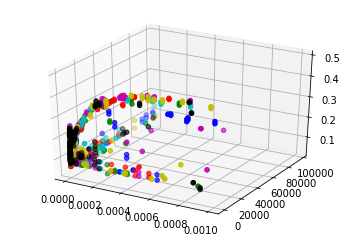

hs 1.000000e+01 lr 1.282452e-08 reg 2.048464e+04 decay 9.500000e-01 train accuracy: 0.098429 val accuracy: 0.096000
hs 1.000000e+01 lr 1.282452e-08 reg 2.048464e+04 decay 9.900000e-01 train accuracy: 0.095694 val accuracy: 0.095000
hs 1.000000e+01 lr 1.288009e-08 reg 2.413854e+02 decay 9.500000e-01 train accuracy: 0.108082 val accuracy: 0.123000
hs 1.000000e+01 lr 1.288009e-08 reg 2.413854e+02 decay 9.900000e-01 train accuracy: 0.077857 val accuracy: 0.092000
hs 1.000000e+01 lr 1.852300e-08 reg 1.184751e+00 decay 9.500000e-01 train accuracy: 0.098327 val accuracy: 0.094000
hs 1.000000e+01 lr 1.852300e-08 reg 1.184751e+00 decay 9.900000e-01 train accuracy: 0.070510 val accuracy: 0.075000
hs 1.000000e+01 lr 1.896440e-08 reg 1.092061e-04 decay 9.500000e-01 train accuracy: 0.113367 val accuracy: 0.112000
hs 1.000000e+01 lr 1.896440e-08 reg 1.092061e-04 decay 9.900000e-01 train accuracy: 0.118510 val accuracy: 0.113000
hs 1.000000e+01 lr 1.965352e-08 reg 4.150444e-03 decay 9.500000e-01 trai

In [11]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
results = {}
best_val = -1
best_net = None
#learning_rates = [1e-8, 1e-7, 5e-7, 1e-6, 1e-5, 1e-4]
#regularization_strengths = [1e3, 1e4, 2.5e4, 5e4]
rate_decays = [0.95,0.99] #[0.99, 0.95, 0.9, 0.8, 0.7, 0.6]
hidden_sizes = [10, 50, 70, 80, 100, 120, 150]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
num_iters = 1000 # tmp for development
max_count = 70

fig = plt.figure()
#plt.ion()
plt.hold(False)
ax = fig.add_subplot(111, projection='3d')
xs = []
ys = []
zs = []
c = []
ax.set_xlabel('rate')
ax.set_ylabel('strength')
ax.set_zlabel('validation_accuracy')

for ind, hidden_size in enumerate(hidden_sizes):
    tic = time.time()
    for count in range(max_count):
        rate = 10**np.random.uniform(-3, -8)
        strength = 10**np.random.uniform(-5, 5)
        for decay in rate_decays:
            myNet = TwoLayerNet(input_size, hidden_size, num_classes)
            myNet.train(X_train, y_train, X_val, y_val, learning_rate=rate, reg=strength,
                      learning_rate_decay=decay, num_iters=num_iters, verbose=False)
            y_train_pred = myNet.predict(X_train)
            training_accuracy = np.mean(y_train == y_train_pred)
            y_val_pred = myNet.predict(X_val)
            validation_accuracy = np.mean(y_val == y_val_pred)
            results[(hidden_size, rate, strength, decay)] = (training_accuracy,validation_accuracy)
            if validation_accuracy > best_val:
                best_val = validation_accuracy
                best_net = myNet
            print(count,' hs ',hidden_size,' lr ',rate,' reg ',strength,' decay ',decay,' train accuracy: ',training_accuracy,' val accuracy: ',validation_accuracy)
            xs.append(rate)
            ys.append(strength)
            zs.append(validation_accuracy)
            c.append(colors[ind])
    toc = time.time()
    print('computed in ',( toc - tic),'s')
ax.scatter(xs, ys, zs, c=c)
plt.show()
# Print out results.
for hs, lr, reg, decay in sorted(results):
    train_accuracy, val_accuracy = results[(hs, lr, reg, decay)]
    print('hs %e lr %e reg %e decay %e train accuracy: %f val accuracy: %f' % (
                hs, lr, reg, decay, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

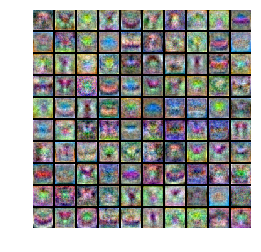

In [12]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

In [13]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.469
